## Android Tap and Sensor Fusion

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os
import ast

##### Sensor Data Parser

In [2]:
ls ../Data/SensorInfo/

201711091951  201711092033  201711161638


In [3]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

##### Tap Data Parser

In [4]:
ls ../Data/TapInfo/

ml16-141402-201711091951-export.json  ml16-141402-201711161638-export.json
ml16-141402-201711092033-export.json


In [5]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

### Load all data

In [21]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [22]:
for filename in glob.glob('../Data/SensorInfo/201711*'):
    key=filename.split('/')[-1]
    print(key)
    accData[key],gyrData[key],magData[key]=parseSensorData(filename)

201711092033
201711161638
201711091951


In [23]:
for filename in glob.glob('../Data/TapInfo/ml16-141402-201711*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033
201711161638


### Data Integration & Feature Extraction

In [24]:
data=od()

In [10]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        a=acc.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        g=gyr.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        m=mag.query('timestamp>='+str(row['downTime'])+'and timestamp<='+str(row['eventTime']))
        d=pd.concat([
           pd.DataFrame([row['actionButton']],columns=['target']).T,
            a.apply(mean).rename(lambda x:x+'_mean').T,
            a.apply(var).rename(lambda x:x+'_var'),
            a.apply(skew).rename(lambda x:x+'_skew'),
            a.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            g.apply(mean).rename(lambda x:x+'_mean'),
            g.apply(var).rename(lambda x:x+'_var'),
            g.apply(skew).rename(lambda x:x+'_skew'),
            g.apply(kurtosis).rename(lambda x:x+'_kurtosis'),
            m.apply(mean).rename(lambda x:x+'_mean'),
            m.apply(var).rename(lambda x:x+'_var'),
            m.apply(skew).rename(lambda x:x+'_skew'),
            m.apply(kurtosis).rename(lambda x:x+'_kurtosis')]
            ,axis=0).T
        df=df.append([d],ignore_index=True)
    return df

In [11]:
for key in tapData.keys():
        data[key]=fusion(accData[key], gyrData[key], magData[key], tapData[key])

In [12]:
for key in data.keys():
    data[key].to_csv('../Data/Features/'+str(key)+'_features.csv')

In [13]:
def plotSensor(data):
    for key in data.keys():
        data[key].plot(title=key)
    plt.show()

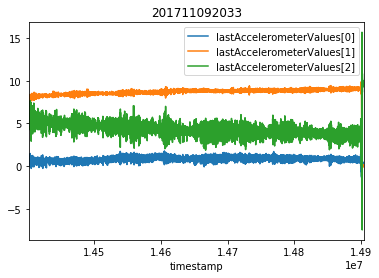

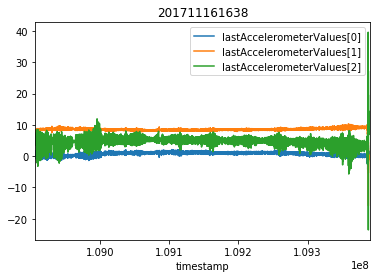

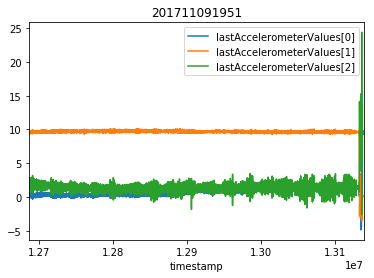

In [14]:
plotSensor(accData)

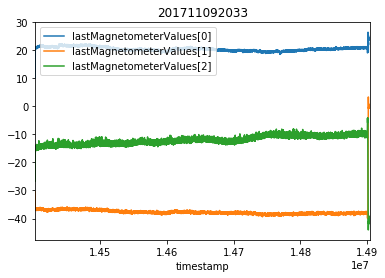

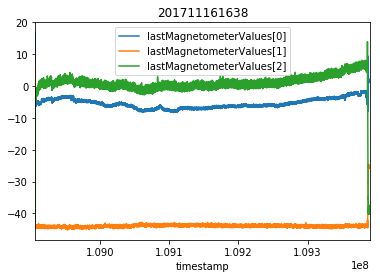

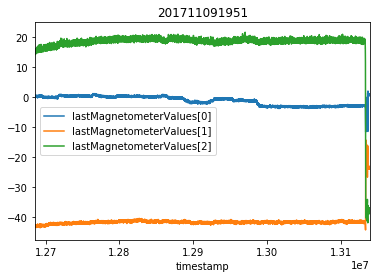

In [15]:
plotSensor(magData)

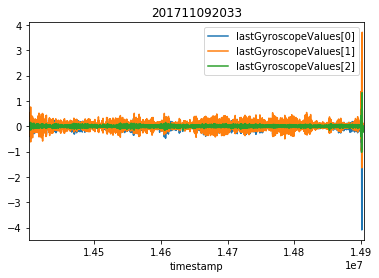

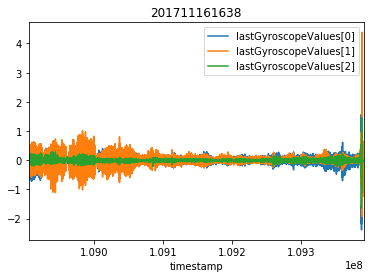

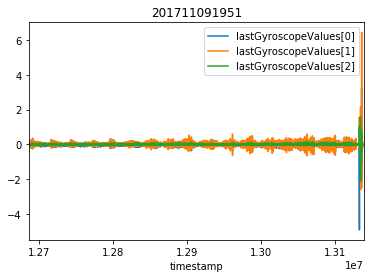

In [16]:
plotSensor(gyrData)

In [53]:
key = '201711161638'
a,g,m,t = accData[key], gyrData[key], magData[key], tapData[key]

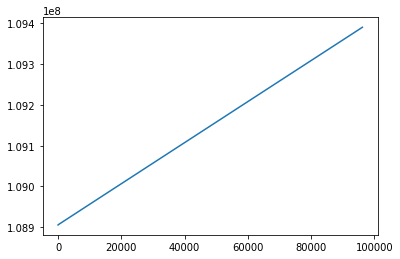

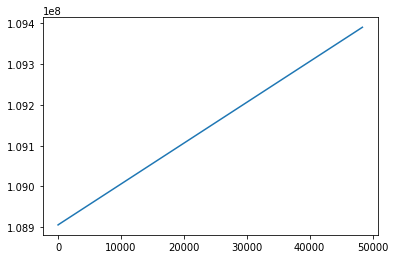

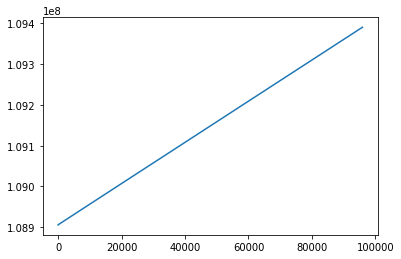

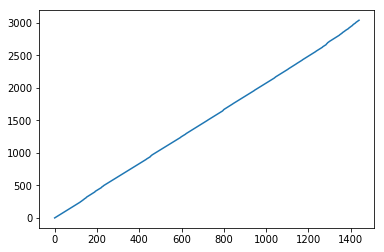

In [55]:
plt.plot(list(a.index))
plt.show()
plt.plot(list(m.index))
plt.show()
plt.plot(list(g.index))
plt.show()
plt.plot(list(t.index))
plt.show()


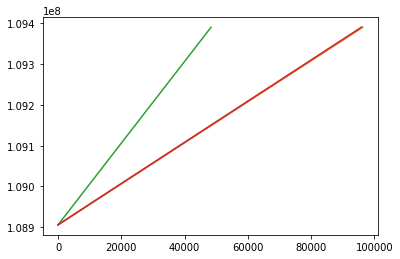

In [51]:
plt.show().q`

In [97]:
from scipy.stats import norm
def plotTapIntervalDist(t):
    ax = sns.distplot((t.eventTime-t.downTime),fit=norm, kde=False)


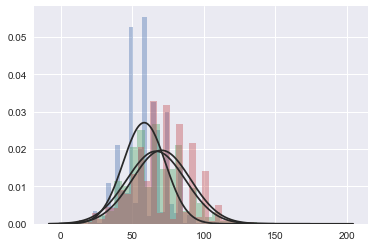

In [98]:
for key in tapData.keys():
    plotTapIntervalDist(tapData[key])

In [128]:
import seaborn as sns, numpy as np
%matplotlib inline
import matplotlib.dates as dates
import statsmodels.api as sm

In [130]:
def plotSensor(s):
    from pylab import rcParams
    rcParams['figure.figsize'] = 11, 9

    decomposition = sm.tsa.seasonal_decompose(s, model='additive')
    fig = decomposition.plot()
    plt.show()


In [131]:
plotSensor(a)

AttributeError: 'Int64Index' object has no attribute 'inferred_freq'

# fin.

In [ ]:
a = a.set_index(pd.DatetimeIndex(df['b']))

In [141]:
a.index.astype(int)

Int64Index([108905671, 108905672, 108905673, 108905674, 108905675, 108905676,
            108905682, 108905821, 108905822, 108905823,
            ...
            109390355, 109390360, 109390364, 109390369, 109390374, 109390380,
            109390385, 109390392, 109390395, 109390400],
           dtype='int64', name=u'timestamp', length=96260)

UnboundLocalError: local variable 'x' referenced before assignment

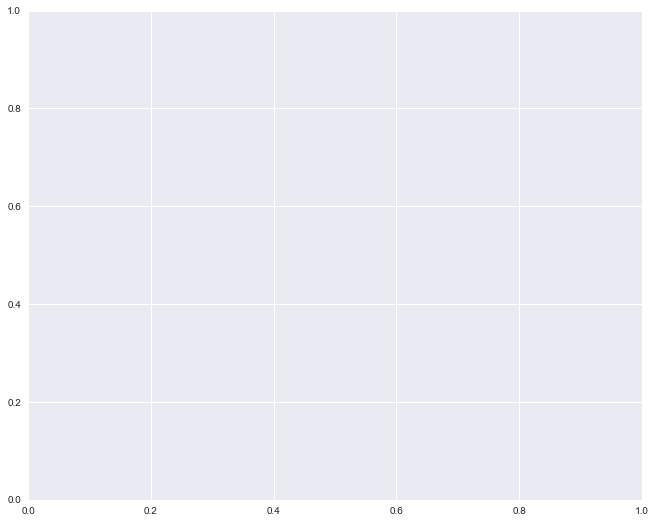

In [139]:
sns.tsplot(a)